In [1]:
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
from utils import *
import pandas as pd

In [2]:
directory = 'images/final/'
width = 64
height = 64
channels = 4
image_size = (width, height)
input_shape = (width, height, channels)
batch_size = 32

In [3]:
train_ds, class_names = load_data(directory, batch_size, image_size, GAN=True)

Found 13849 files belonging to 905 classes.


In [4]:
train_ds.cardinality().numpy()

433

In [5]:
types = pd.read_csv('PokeDataset.csv', usecols=['Name', 'Type1', 'Type2'])
# reorder by alphabetical order of column 'Name'
types = types.sort_values(by=['Name'])
types = types.reset_index(drop=True)

In [6]:
# give percentage of pokemon with double type
print(f"Percentage of pokemon with double type: {types['Type2'].count() / types['Type1'].count() * 100:.2f}%")

Percentage of pokemon with double type: 49.61%


In [7]:
types.head(5)

,Name,Type1,Type2
0,Abomasnow,Grass,Ice
1,Abra,Psychic,NaN
2,Absol,Dark,NaN
3,Accelgor,Bug,NaN
4,Aegislash,Steel,Ghost


In [8]:
# make a dictionary of types and their index in the list of types
types_dict = {}
for i, t in enumerate(types['Type1'].unique()):
    types_dict[t] = i

# create vector of labels with 0 for each type except the one in the row (type1 and type2 are strings)
def create_label(row):
    label = np.zeros(18)
    label[types_dict[row['Type1']]] = 1
    if row['Type2'] in types_dict:
        label[types_dict[row['Type2']]] = 1
    return label

types['Label'] = types.apply(create_label, axis=1)

In [9]:
def types_to_vector(type1, type2=None):
    label = np.zeros(18)
    label[types_dict[type1]] = 1
    if type2 in types_dict:
        label[types_dict[type2]] = 1
    return label.reshape(1, 18)

In [10]:
for x, y in train_ds.take(1):
    print(int(tf.argmax(tf.reshape(y[0], [-1, 1]), axis=0)))
    plot_image(x[0], class_names[int(tf.argmax(tf.reshape(y[0], [-1, 1]), axis=0))], size=64)

521


In [11]:
# map labels in train_ds to the column Label in types
def map_labels(x, y):
    y_onehot = tf.argmax(y, axis=1).numpy()
    y_labels = np.zeros((len(y_onehot), 18))
    for i in range(len(y_onehot)):
        y_labels[i] = types.loc[y_onehot[i], 'Label']
    y_label = np.insert(y_labels, 0, 1, axis=1)
    y_label_tensor = tf.convert_to_tensor(y_label, dtype=tf.float32)
    return x, y_label_tensor

train_ds = train_ds.map(lambda x, y: tf.py_function(map_labels, [x, y], [tf.float32, tf.float32]))


In [12]:
train_ds = prepare(train_ds, shuffle=True, augment=False, GAN=True)

channels = 3
input_shape = (width, height, channels)

In [13]:
plot_n_images(train_ds, 5, class_names, GAN=True, size=width)

tf.Tensor([1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(19,), dtype=float32)
(64, 64, 3)


tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.], shape=(19,), dtype=float32)
(64, 64, 3)


tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.], shape=(19,), dtype=float32)
(64, 64, 3)


tf.Tensor([1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(19,), dtype=float32)
(64, 64, 3)


tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(19,), dtype=float32)
(64, 64, 3)


In [14]:
# define the discriminator model
def define_cdiscriminator(input_shape, num_classes):
    img_input = tf.keras.layers.Input(shape=input_shape)
    label_input = tf.keras.layers.Input(shape=(num_classes,))
    
    # image branch
    layer = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(img_input)
    layer = tf.keras.layers.LeakyReLU(alpha=0.2)(layer)
    layer = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(layer)
    layer = tf.keras.layers.LeakyReLU(alpha=0.2)(layer)
    layer = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(layer)
    layer = tf.keras.layers.LeakyReLU(alpha=0.2)(layer)
    layer = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(layer)
    layer = tf.keras.layers.LeakyReLU(alpha=0.2)(layer)
    layer = tf.keras.layers.Flatten()(layer)

    # label branch
    label_layer = tf.keras.layers.Dense(64)(label_input)
    label_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(label_layer)
    label_layer = tf.keras.layers.Dense(128)(label_layer)
    label_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(label_layer)
    label_layer = tf.keras.layers.Dense(256)(label_layer)
    label_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(label_layer)
    label_layer = tf.keras.layers.Dense(256)(label_layer)
    label_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(label_layer)
    label_layer = tf.keras.layers.Flatten()(label_layer)

    # concatenate image and label branches
    layer = tf.keras.layers.concatenate([layer, label_layer])
    layer = tf.keras.layers.Dropout(0.4)(layer)
    layer = tf.keras.layers.Dense(1, activation='sigmoid')(layer)
    
    # define the model
    model = tf.keras.models.Model(inputs=[img_input, label_input], outputs=layer)

    # compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

    
# define the standalone generator model
def define_cgenerator(latent_dim, num_classes):
    # Define the noise vector input
    in_lat = tf.keras.layers.Input(shape=(latent_dim,))
    # Define the class vector input
    in_class = tf.keras.layers.Input(shape=(num_classes,))
    # Concatenate the noise and class vectors
    merge = tf.keras.layers.Concatenate()([in_lat, in_class])
    # Project the concatenated vector to a larger dimension
    n_nodes = 256 * 8 * 8
    dense = tf.keras.layers.Dense(n_nodes)(merge)
    # Reshape the dense layer output
    reshaped = tf.keras.layers.Reshape((8, 8, 256))(dense)
    # Upsample the feature maps
    upsampled = tf.keras.layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same')(reshaped)
    upsampled = tf.keras.layers.LeakyReLU(alpha=0.2)(upsampled)
    upsampled = tf.keras.layers.Conv2DTranspose(256, (4,4), strides=(2,2), padding='same')(upsampled)
    upsampled = tf.keras.layers.LeakyReLU(alpha=0.2)(upsampled)
    upsampled = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(upsampled)
    upsampled = tf.keras.layers.LeakyReLU(alpha=0.2)(upsampled)
    # Output layer
    out_layer = tf.keras.layers.Conv2D(3, (3,3), activation='tanh', padding='same')(upsampled)
    # Define the model
    model = tf.keras.models.Model([in_lat, in_class], out_layer)
    return model

In [15]:
def define_cgan(g_model, d_model):
    d_model.trainable = False
    gen_noise, gen_label = g_model.input
    gen_output = g_model.output
    gan_output = d_model([gen_output, gen_label])
    model = tf.keras.Model([gen_noise, gen_label], gan_output)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


In [16]:
# build and compile the discriminator
cdiscriminator = define_cdiscriminator((64, 64, 3), 18)
# cdiscriminator.summary()

In [17]:
# build the generator
cgenerator = define_cgenerator(100, 18)
# cgenerator.summary()

In [18]:
# build the gan
cgan_model = define_cgan(cgenerator, cdiscriminator)
# cgan_model.summary()

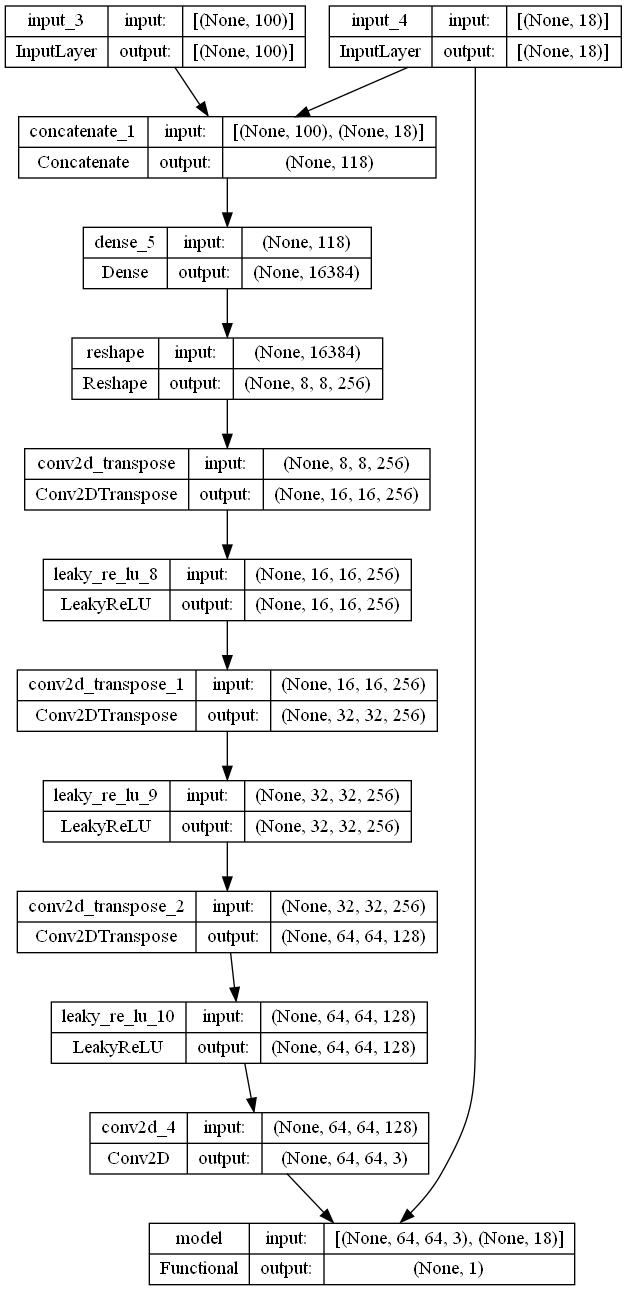

In [19]:
dot_img_file = '/CGAN.png'
tf.keras.utils.plot_model(cgan_model, to_file=dot_img_file, show_shapes=True)

In [20]:
def generate_fake_samples(g_model, latent_dim, n_samples, n_classes):
    # generate points in latent space
    noise_input = generate_latent_points(latent_dim, n_samples)
    # generate random class labels
    y_types = generate_class_labels(n_samples, n_classes)
    # predict outputs
    X = g_model.predict([noise_input, y_types], verbose=0)
    # # create 'fake' class labels (0)
    y_class = tf.zeros((n_samples, 1))
    return X, y_types, y_class

def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = tf.random.normal(shape=(n_samples, latent_dim))
    return x_input

def generate_class_labels(n_samples, n_classes):
    class_labels = np.zeros((n_samples, n_classes))
    for i in range(n_samples):
        class_labels[i, np.random.randint(0, n_classes)] = 1
        if np.random.random() > 0.5:
            class_labels[i, np.random.randint(0, n_classes)] = 1
    class_labels = tf.convert_to_tensor(class_labels, dtype=tf.float32)
    return class_labels

def generate_real_samples(dataset, n_samples):
    X, y_types, y_class = [], [], []
    while len(X) < n_samples:
        dataset.shuffle(100, seed=123)
        for x, label in dataset.take(5):
            for i in range(len(x)):
                X.append(x[i])
                y_types.append(label[i][1:])
                y_class.append(label[i][0])
                if len(X) == n_samples:
                    break
            if len(X) == n_samples:
                break
    X = tf.stack(X)
    y_types = tf.stack(y_types)
    y_class = tf.reshape(tf.stack(y_class), (n_samples, 1))
    return X, y_types, y_class

In [21]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real_types, y_real_class = generate_real_samples(dataset, n_samples)
    print(X_real.shape, y_real_types.shape, y_real_class.shape)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate([X_real, y_real_types], y_real_class, verbose=0)
    # prepare fake examples
    x_fake, y_fake_types, y_fake_class = generate_fake_samples(g_model, latent_dim, n_samples, 18)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate([x_fake, y_fake_types], y_fake_class, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'cgenerator_model_64_e%03d.h5' % (epoch+1)
    g_model.save(filename)

def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # scale from [-1,1] to [0,1]
        examples[i, :, :, :] = (examples[i, :, :, :] + 1) / 2.0
        # plot raw pixel data
        plt.imshow(examples[i, :, :, :])
    # save plot to file
    filename = 'cgenerated_plot_64_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [22]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64):
    bat_per_epo = int(dataset.cardinality())
    # print(bat_per_epo)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j, batch in enumerate(dataset):
            # get randomly selected 'real' samples
            X_real, y_real_types, y_real_class = batch[0], batch[1][:, 1:], batch[1][:, 0]
            # print(y_real_types[0])
            # plot_image(X_real[0], str(y_real_class[0]), size=64)
            half_batch = int(X_real.shape[0])
            # generate 'fake' examples
            X_fake, y_fake_types, y_fake_class = generate_fake_samples(g_model, latent_dim, half_batch, 18)
            # print(y_fake_types[0])
            # plot_image(X_fake[0], str(y_fake_class[0]), size=64)
            # create training set for the discriminator
            y_real_class = tf.reshape(y_real_class, (half_batch, 1))
            X, y_types, y_class = tf.concat([X_real, X_fake], axis=0), tf.concat([y_real_types, y_fake_types], axis=0), tf.concat([y_real_class, y_fake_class], axis=0)
            # update discriminator model weights
            # print("\ntraining on both real and fake for discriminator...\n")
            d_loss, _ = d_model.train_on_batch([X, y_types], y_class)
            # prepare points in latent space as input for the generator
            X_gan, y_gan_types, y_gan_class = generate_latent_points(latent_dim, n_batch), generate_class_labels(n_batch, 18), tf.ones((n_batch, 1))
            # print(X_gan.shape, y_gan_types.shape, y_gan_class.shape)
            # print(y_gan_types[0])
            # print(y_gan_class[0])
            # print("\ntraining on random latent points for generator...\n")
            g_loss = gan_model.train_on_batch([X_gan, y_gan_types], y_gan_class)
            # summarize loss on this batch
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
            # break
        # evaluate the model performance, sometimes
        if (i) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
    # save the generator model
    g_model.save('cgenerator_model_64_final.h5')


In [23]:
# size of the latent space
latent_dim = 100
# train model
train(cgenerator, cdiscriminator, cgan_model, train_ds, latent_dim, n_epochs=1)


>1, 1/433, d=0.690, g=0.691
>1, 2/433, d=0.536, g=0.677
>1, 3/433, d=0.438, g=0.625
>1, 4/433, d=0.452, g=0.558
>1, 5/433, d=0.530, g=0.545
>1, 6/433, d=0.539, g=0.610
>1, 7/433, d=0.517, g=0.698
>1, 8/433, d=0.493, g=0.766
>1, 9/433, d=0.498, g=0.909
>1, 10/433, d=0.518, g=0.791
>1, 11/433, d=0.564, g=1.076
>1, 12/433, d=0.532, g=0.673
>1, 13/433, d=0.496, g=0.971
>1, 14/433, d=0.488, g=0.837
>1, 15/433, d=0.407, g=0.771
>1, 16/433, d=0.421, g=0.937
>1, 17/433, d=0.360, g=1.010
>1, 18/433, d=0.309, g=1.122
>1, 19/433, d=0.310, g=1.056
>1, 20/433, d=0.320, g=1.049
>1, 21/433, d=0.341, g=0.782
>1, 22/433, d=0.359, g=0.832
>1, 23/433, d=0.394, g=0.955
>1, 24/433, d=0.352, g=0.994
>1, 25/433, d=0.314, g=1.216
>1, 26/433, d=0.308, g=1.058
>1, 27/433, d=0.390, g=1.799
>1, 28/433, d=0.747, g=0.558
>1, 29/433, d=0.981, g=0.760
>1, 30/433, d=0.589, g=1.259
>1, 31/433, d=0.677, g=1.274
>1, 32/433, d=0.503, g=1.179
>1, 33/433, d=0.401, g=1.458
>1, 34/433, d=0.415, g=1.683
>1, 35/433, d=0.435, g=

In [24]:
# save model to resume training
cgenerator.save('cgenerator_model_64.h5')
cdiscriminator.save_weights('cdiscriminator_model_64.h5')
# cdiscriminator.save('cdiscriminator_model_64.h5')
cgan_model.save('cgan_model_64.h5')

test

In [26]:
generator = tf.keras.models.load_model('cgenerator_model_64.h5')
discriminator = define_cdiscriminator((64, 64, 3), 18)
discriminator.load_weights('cdiscriminator_model_64.h5')
# discriminator = tf.keras.models.load_model('cdiscriminator_model_64.h5')
gan_model = tf.keras.models.load_model('cgan_model_64.h5')

In [27]:
train(generator, discriminator, gan_model, train_ds, latent_dim, n_epochs=1)

>1, 1/433, d=0.549, g=0.957
>1, 2/433, d=0.445, g=0.812
>1, 3/433, d=0.275, g=0.677
>1, 4/433, d=0.250, g=0.547
>1, 5/433, d=0.128, g=0.506
>1, 6/433, d=0.100, g=0.474
>1, 7/433, d=0.111, g=0.365
>1, 8/433, d=0.133, g=0.362
>1, 9/433, d=0.116, g=0.306
>1, 10/433, d=0.056, g=0.300
>1, 11/433, d=0.072, g=0.243
>1, 12/433, d=0.066, g=0.223
>1, 13/433, d=0.035, g=0.202
>1, 14/433, d=0.033, g=0.154
>1, 15/433, d=0.069, g=0.154
>1, 16/433, d=0.026, g=0.175
>1, 17/433, d=0.011, g=0.122
>1, 18/433, d=0.014, g=0.120
>1, 19/433, d=0.013, g=0.092
>1, 20/433, d=0.016, g=0.094
>1, 21/433, d=0.017, g=0.056
>1, 22/433, d=0.018, g=0.071
>1, 23/433, d=0.007, g=0.077
>1, 24/433, d=0.012, g=0.076
>1, 25/433, d=0.014, g=0.054
>1, 26/433, d=0.019, g=0.045
>1, 27/433, d=0.005, g=0.054
>1, 28/433, d=0.008, g=0.039
>1, 29/433, d=0.026, g=0.034
>1, 30/433, d=0.048, g=0.040
>1, 31/433, d=0.010, g=0.033
>1, 32/433, d=0.006, g=0.037
>1, 33/433, d=0.015, g=0.036
>1, 34/433, d=0.007, g=0.028
>1, 35/433, d=0.010, g=

In [31]:
X = cgenerator.predict([generate_latent_points(100, 1), types_to_vector('Fire')], verbose=0)
plot_image(X[0], "image générée", {"real": cdiscriminator.predict([X, types_to_vector('Fire')], verbose=0)[0][0]}, 64)

In [29]:
# test image with random noise between -1 and 1
test_image_noise = tf.random.uniform(shape=(1, 64, 64, 3), minval=-1, maxval=1)

In [30]:
plot_image(test_image_noise[0], "image test", {"real": cdiscriminator.predict([test_image_noise, types_to_vector('Grass')], verbose=0)[0][0]})

In [31]:
# load images/test/charmander.png to test
test_image = tf.keras.preprocessing.image.load_img('images/test/charmander.png', color_mode='rgba', target_size=image_size)
test_image = tf.keras.preprocessing.image.img_to_array(test_image)
test_image = tf.expand_dims(test_image, axis=0)
test_image = preprocess_image(test_image)
print(test_image.shape)

(1, 64, 64, 3)


In [32]:
# test discriminator with test image
plot_image(test_image[0], "image test", {"real": cdiscriminator.predict([test_image, types_to_vector('Fire')], verbose=0)[0][0]})